In [56]:
# This code will perform perform SVD on the A matrix and extract the relevant coherent structures

In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Read Input
def read_variables_to_globals(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]

    for i in range(0, len(lines), 2):
        var_name = lines[i]
        raw_value = lines[i+1]

        try:
            value = int(raw_value)
        except ValueError:
            try:
                value = float(raw_value)
            except ValueError:
                value = raw_value

        globals()[var_name] = value  # Define variable in global scope

In [59]:
# Perform SVD on a normal computer
# Compute Correlation matrix 
#   -> Compute eigenvectors (temporal modes) and square root of eigenvalues of correlation matrix (singular values)
#       ->
def POD_regular(ProjectName, NumSS, NumModes):
    # NumSS == Number of Snapshots -> Determines how big the square matrix is 

    
    print("peepeepoopoo")

In [60]:
# This Block is for validating the above block to make sure that what it is outputting makes sense
def POD_regular_validate(ProjectName):
    SnapShotMat_filename = ProjectName + "_SnapShot_Mat.txt"
    SnapShot_Mat = np.loadtxt(SnapShotMat_filename)
    U, S, Vt = np.linalg.svd(SnapShot_Mat, full_matrices=False)
    print("From validation:")
    print("U =", U)
    print("S =", S)
    print("V^T =", Vt)
    return U, S, Vt

In [61]:
# Plot Log of normalized singular values
def plot_singular(S):
    # Create the plot

    x = np.arange(1, len(S) + 1)
    plt.plot(x, S)

    # Add labels and title
    plt.xlabel('Singular Values')
    plt.ylabel('Value')
    plt.title('SV Power Spectra')

    # Show the plot
    plt.show()

In [62]:
def main(ProjectName, NumSS, NumModes):
    # SVD for computation of 
    U, S, Vt = POD_regular(ProjectName, NumSS, NumModes)
    # SVD on complete matrix for validation
    U_val, S_val, Vt_val = POD_regular_validate(ProjectName)

    return U_val, S_val, Vt_val

From validation:
U = [[-0.32261176  0.10665428 -0.12530136  0.10109236 -0.18238453]
 [-0.38752193  0.08684118 -0.03786345 -0.11934079  0.61378366]
 [-0.29491243  0.44701689 -0.12816683  0.04606412  0.01497432]
 [-0.28320617 -0.21769616  0.47646443 -0.44781056  0.18217303]
 [-0.3353448   0.17638409  0.68466557  0.14687302 -0.15353785]
 [-0.30070683 -0.39952631  0.03602862  0.31324685 -0.10314979]
 [-0.33181823 -0.49676266 -0.19888491 -0.25119028 -0.49745568]
 [-0.31918548  0.49344361 -0.24594204 -0.31867236 -0.3491888 ]
 [-0.29505606 -0.22982104 -0.40623934 -0.08044006  0.38978175]
 [-0.2768534  -0.00759595 -0.0654426   0.69431073  0.03249188]]
S = [44.18105164 13.08418101 10.67028131  8.38289546  3.42214017]
V^T = [[-0.48261011 -0.50118597 -0.4600497  -0.36336126 -0.41499755]
 [-0.26972765 -0.61282255  0.14762291  0.22648594  0.69181436]
 [ 0.37087019  0.01948682 -0.85177599  0.26596902  0.25654183]
 [-0.44749461  0.1298917  -0.03179329  0.82343846 -0.32220338]
 [-0.59710832  0.5966653

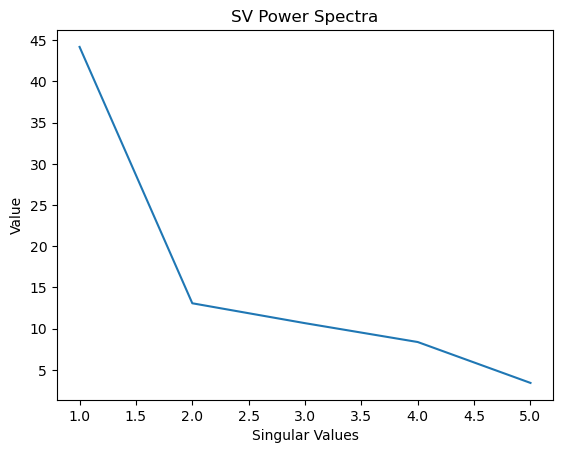

In [63]:
if __name__ == "__main__":
    # Read Variables
    inputs = read_variables_to_globals("input_POD.txt")
    
    U, S, Vt = main(ProjectName)

    plot_singular(S)